# Register Golf Club
목표: 골프 클럽 데이터를 활용하여 회귀 트리 모델을 구현  

- 데이터 소개
    - 데이터: 골프 클럽 가입 여부에 대한 정보
        - 14개의 행과 6개의 열로 구성
    - 특성: 나이, 소득, 결혼 여부, 신용 점수
    - 목표 변수: register_golf_club 열은 가입 여부

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

## 함수 구현

Information Gain과 entropy 함수를 구현한 이유는 의사 결정 트리(Decision Tree) 알고리즘에서 특성을 선택하는 데 사용되기 때문이다.  

의사 결정 트리는 데이터를 분할하는 과정에서 각 특성을 기반으로 정보 이득을 계산하여 가장 중요한 특성을 선택한다. Information Gain과 entropy 함수를 구현하여 가장 중요한 특성을 선택하는 과정을 자동화하고, 의사 결정 트리 알고리즘이 데이터를 분할하는 데 사용된다.

### entropy 함수 

Entropy 함수
- 해당 레이블 집합의 불확실성
- 정보 이득을 계산하기 위해 사용

In [2]:
def get_entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)       # 각 레이블의 개수를 계산
    probabilities = label_counts / len(labels)                                # 레이블의 개수를 전체 데이터 개수로 나누어 확률을 계산
    entropy = -np.sum(probabilities * np.log2(probabilities))                 # 확률에 로그를 적용하여 엔트로피를 계산
    return entropy

### Information Gain 함수 구현

정보 이득 
- 분할 전 후의 엔트로피 감소량
    - 현재 상태의 엔트로피에서 특정 특성을 기반으로 분할한 후의 가중 평균 엔트로피를 뺀 값으로 계산
- 분할 후 불확실성이 줄어든 정도  
따라서 정보 이득이 높은 특성이 분류나 회귀에 더 유용한 특성이라고 판단된다.

In [3]:
def get_IG(feature, labels):
    feature_values = np.unique(feature)                                        # 특성의 고유한 값들을 가져옴
    total_entropy = get_entropy(labels)                                        # 전체 데이터의 엔트로피를 계산
    weighted_entropy = 0
    for value in feature_values:
        subset_labels = labels[feature == value]                               # 해당 특성 값에 해당하는 레이블만 추출
        subset_entropy = get_entropy(subset_labels)                            # 해당 특성 값에 대한 엔트로피 계산
        weighted_entropy += len(subset_labels) / len(labels) * subset_entropy  # 해당 특성 값의 가중 엔트로피 계산
    information_gain = total_entropy - weighted_entropy                        # 정보 이득 계산
    return information_gain

## CSV 파일 로드

In [4]:
register_golf_club = pd.read_csv('/Users/project/python/regression/register_golf_club.csv')
register_golf_club.head()

,Index,age,income,married,credit_score,register_golf_club
0,1,young,high,no,normal,no
1,2,young,high,no,good,no
2,3,middle,high,no,normal,yes
3,4,old,medium,no,normal,yes
4,5,old,low,yes,normal,yes


### 데이터 확인

In [7]:
print(f'register_golf_club shape = {register_golf_club.shape}')

register_golf_club shape = (14, 6)


In [6]:
print(f'register_golf_club info \n{register_golf_club.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Index               14 non-null     int64 
 1   age                 14 non-null     object
 2   income              14 non-null     object
 3   married             14 non-null     object
 4   credit_score        14 non-null     object
 5   register_golf_club  14 non-null     object
dtypes: int64(1), object(5)
memory usage: 804.0+ bytes
register_golf_club info 
None


## 입력 특성과 타겟 분리

In [8]:
X = register_golf_club.iloc[:, 1:-1]    # 첫번째 열, 마지막 열 제외한 나머지 열은 입력 특성
y = register_golf_club.iloc[:, -1]      # 마지막 열은 타겟 변수

### 범주형 데이터를 숫자로 변환

In [9]:
X_encoded = pd.get_dummies(X, columns=['age', 'income', 'married', 'credit_score'])
X_encoded

,age_middle,age_old,age_young,income_high,income_low,income_medium,married_no,married_yes,credit_score_good,credit_score_normal
0,False,False,True,True,False,False,True,False,False,True
1,False,False,True,True,False,False,True,False,True,False
2,True,False,False,True,False,False,True,False,False,True
3,False,True,False,False,False,True,True,False,False,True
4,False,True,False,False,True,False,False,True,False,True
5,False,True,False,False,True,False,False,True,True,False
6,True,False,False,False,True,False,False,True,True,False
7,False,False,True,False,False,True,True,False,False,True
8,False,False,True,False,True,False,False,True,False,True
9,False,True,False,False,False,True,False,True,False,True


### 타겟 변수를 숫자로 변화

In [10]:
y_encoded = y.map({'no': 0, 'yes': 1})
y_encoded

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: register_golf_club, dtype: int64

### Root node에서의 descriptive feature 선정과 Information Gain 계산

In [11]:
information_gains = []
for feature in X_encoded.columns:
    information_gain = get_IG(X_encoded[feature], y_encoded)        # 특성(feature)과 레이블(labels)을 기반으로 정보 이득을 계산
    information_gains.append((feature, information_gain))           # 특성과 정보 이득을 리스트에 추가

best_feature, best_IG = max(information_gains, key=lambda x: x[1])  # 정보 이득이 가장 큰 특성을 찾음
print(f'descriptive feature: {best_feature}')                       # 가장 큰 정보 이득을 가지는 특성 출력
print(f'Information Gain: {best_IG}')                               # 해당 특성의 정보 이득 출력

descriptive feature: age_middle
Information Gain: 0.22600024438491684


## 훈련 데이터와 테스트 데이터 분할

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded,
                                                    test_size=0.2, random_state=11)

In [13]:
print(f'X train shape : {X_train.shape}')
print(f'y train shape : {y_train.shape}')
print(f'X test shape : {X_test.shape}')
print(f'y test shape : {y_test.shape}')

X train shape : (11, 10)
y train shape : (11,)
X test shape : (3, 10)
y test shape : (3,)


## DecisionTreeClassifier 모델 생성

In [14]:
model = DecisionTreeClassifier(criterion='entropy')

### DecisionTreeClassifier 모델 속성 출력

In [16]:
for attr in dir(model):
    if not attr.startswith('_'): print(attr)

apply
ccp_alpha
class_weight
cost_complexity_pruning_path
criterion
decision_path
feature_importances_
fit
get_depth
get_metadata_routing
get_n_leaves
get_params
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
predict
predict_log_proba
predict_proba
random_state
score
set_fit_request
set_params
set_predict_proba_request
set_predict_request
set_score_request
splitter


### 모델 훈련

In [18]:
model.fit(X_train, y_train)
print(f'depth = {model.get_depth()}\nger_n_leaves = {model.get_n_leaves()}')

depth = 4
ger_n_leaves = 5


### 테스트 데이터에 대한 정확도 계산

In [19]:
accuracy = model.score(X_test, y_test)
print(f'{accuracy = }')

accuracy = 0.6666666666666666


## 그래프 그리기

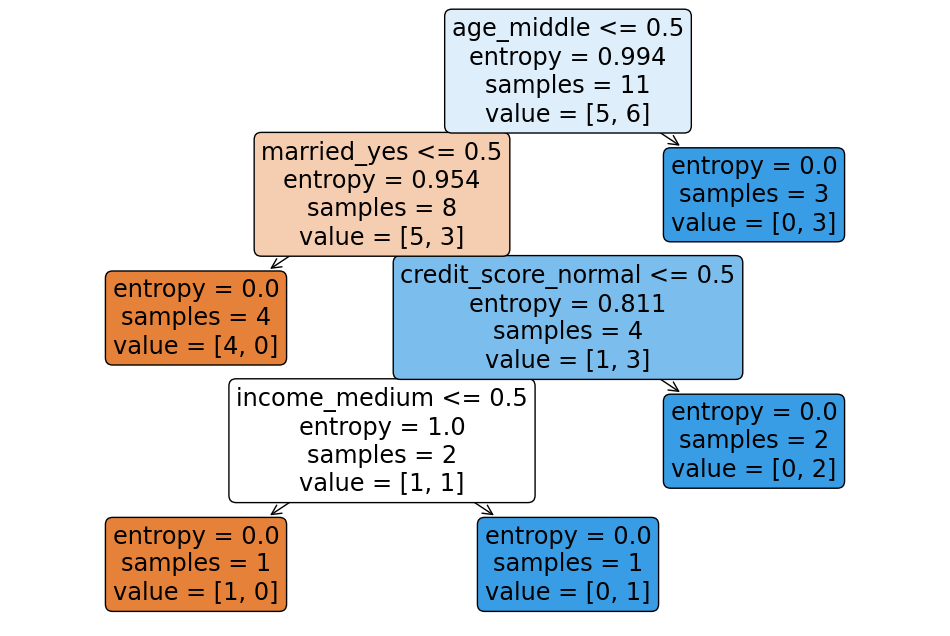

In [23]:
plt.figure(figsize=(12, 8))
tree.plot_tree(model,
               feature_names=X_encoded.columns.tolist(), # X_encoded의 열 이름 사용
               filled=True, rounded=True)
plt.show()

Decision Tree 결과 분석
1. **모델의 구조**
   - 트리의 깊이(depth): depth = 4
     - 트리가 4단계까지 얕게 분할되었음을 의미합니다. 모델은 트리의 깊이가 얕아져서 각각의 결정 경계가 단순화됩니다. 이는 모델이 더 일반적인 경향을 학습하게 되는데, 데이터의 노이즈나 이상에 덜 민감해진다는 것을 의미합니다.
   - 리프 노드의 개수(get_n_leaves): get_n_leaves = 5
     - 더 많은 데이터 포인트를 하나의 리프 노드로 묶을 수 있게 됩니다. 적은 리프 노드 개수는 모델의 일반화 능력을 향상시키는데 도움을 줄 수 있습니다.

2. **모델 정확도**
   - R-squared(결정계수): accuracy = 0.6666666666666666
     - 모델의 테스트 데이터의 변동이 약 66.67% 정도라고 설명할 수 있습니다.

3. **모델 총평**
   - 낮은 깊이와 적은 리프 노드 개수는 모델이 단순해지고 과적합을 방지할 수 있는 효과를 가집니다. 복잡도가 낮아지면서 모델이 데이터의 노이즈나 이상치에 덜 민감해지고, 새로운 데이터에 대한 예측 성능이 개선될 수 있습니다.